In [22]:
import torch
from torch_geometric.data import InMemoryDataset, download_url, Data, Batch
from torch import nn
from torch.nn import functional as F
import os
import pandas as pd
import numpy as np
import pickle
import itertools
import jax
from jax import numpy as jnp
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
import mendeleev
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler, HyperBandForBOHB
from ray.tune.suggest.bohb import TuneBOHB
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

In [6]:
class SCDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, training= True):
        super().__init__(root, transform, pre_transform)
        self.filenames = pd.read_csv("raw/processed_names.csv")
        self.charges = pd.read_csv("raw/mulliken_charges.csv")
        self.magnetic_shieldings = pd.read_csv("raw/magnetic_shielding_tensors.csv")
        self.dipole_moments = pd.read_csv("raw/dipole_moments.csv")
        self.potential_energy = pd.read_csv("raw/potential_energy.csv")
        self.target = pd.read_csv("raw/train.csv")
        self.structures = pd.read_csv("raw/structures.csv")
        self.molecule_names = molecule_names = np.unique(self.potential_energy["molecule_name"])
        if training:
            self.training_mask = np.loadtxt("./raw/training_mask2.csv").astype(bool)
            self.molecule_names = self.molecule_names[self.training_mask]
            
    def len(self) -> int:
        return len(self.molecule_names)
    def standarize(self):
        mms = MinMaxScaler([-4, 4])
        self.charges["mulliken_charge"] = mms.fit_transform(self.charges[["mulliken_charge"]]).squeeze()
        self.magnetic_shieldings.iloc[:, 2:] = mms.fit_transform(self.magnetic_shieldings.iloc[:, 2:])
        self.dipole_moments.iloc[:, 1:] = mms.fit_transform(self.dipole_moments.iloc[:, 1:])
        self.potential_energy["potential_energy"] = mms.fit_transform(self.potential_energy[["potential_energy"]]).squeeze()

    def preprocess(self, k = None):
        charges = self.charges
        magnetic_shieldings = self.magnetic_shieldings
        dipole_moments = self.dipole_moments
        potential_energy = self.potential_energy
        molecule_names = self.molecule_names
        target = self.target
        structures = self.structures
        dfs = [charges, magnetic_shieldings, dipole_moments, potential_energy, target, structures]
        for i in range(len(dfs)):
            dfs[i] = dfs[i].set_index("molecule_name", drop=True)
        charges, magnetic_shieldings, dipole_moments, potential_energy, target, structures = dfs
        atoms = structures["atom"].unique()
        atoms_id = {atoms[i]:i for i in range(len(atoms))}
        training_mask = []
        for x, name in enumerate(list(molecule_names)):
            any_training_edges = True
            coords = structures.loc[name][["x", "y", "z"]].to_numpy()
            n_nodes = coords.shape[0]
            print("{}/{}".format(x + 1, len(molecule_names)), end = "\r")
            # adj_mat
            with open("./processed/{}_adj_mat.csv".format(name), "wb") as f:
                np.savetxt(f, get_distance_matrix(coords, k))
            atom_types = structures.loc[name]["atom"].replace(atoms_id).to_numpy()
            atom_onehot = np.zeros([n_nodes, len(atoms)])
            atom_onehot[np.arange(0, n_nodes), atom_types] = 1
            charge = charges.loc[name]["mulliken_charge"].to_numpy()
            shieldings = magnetic_shieldings.loc[name].iloc[:, 2:].to_numpy()
            node_features = np.concatenate([charge[:, None], shieldings, atom_onehot], axis=1)
            with open("./processed/{}_node_attr.csv".format(name), "wb") as f:
                np.savetxt(f, node_features)
            try:
                edges_target = target.loc[[name]]
                training_mask.append(True)
            except KeyError:
                training_mask.append(False)
                any_training_edges = False
                
            if any_training_edges:
                edges_target["type"] = edges_target["type"].replace(edge_to_int).astype(np.int64)
                scalar_coupling = edges_target.loc[:, ["atom_index_0", "atom_index_1","type","scalar_coupling_constant"]].to_numpy()
            else:
                scalar_coupling = np.array([-1, -1, -1, 0])
            with open("./processed/{}_target.csv".format(name), "wb") as f:
                np.savetxt(f, scalar_coupling)
            # Graph features
            dipole_moment = dipole_moments.loc[name]
            norm_dipole = np.array([np.linalg.norm(dipole_moment)])
            potential = potential_energy.loc[name]
            graph_features = (np.concatenate([dipole_moment, norm_dipole, potential, np.array([n_nodes])]))
            with open("./processed/{}_graph_feautures.csv".format(name), "wb") as f:
                np.savetxt(f, graph_features)
            # edge_features
            edgelist, edgeattr = get_edge_features(coords, dipole_moment)
            with open("./processed/{}_edge_list.csv".format(name), "wb") as f:
                np.savetxt(f, edgelist)
            with open("./processed/{}_edge_attr.csv".format(name), "wb") as f:
                np.savetxt(f, edgeattr)
            # # metaedge
            # incident_edges = edgelist[edgeattr[:,1] == 1]
            # metaedge_list, metaedge_attr = get_metaedge_features(incident_edges, coords)
            # with open("./processed/{}_metaedge_list.csv".format(name), "wb") as f:
            #     np.savetxt(f,  metaedge_list)
            # with open("./processed/{}_metaedge_attr.csv".format(name), "wb") as f:
            #     np.savetxt(f, metaedge_attr)
        with open("./raw/training_mask2.csv".format(name), "wb") as f:
                np.savetxt(f, np.array(training_mask))
                
    def mem_load(self):
        self.mem = {}
        for i, molecule in enumerate(self.molecule_names):
            graph_features = pd.read_csv("./processed/{}_graph_feautures.csv".format(molecule), sep=" ", header=None).to_numpy()
            node_features = pd.read_csv("./processed/{}_node_attr.csv".format(molecule), sep=" ", header=None).to_numpy()
            atomtypes = node_features[:,-5:].argmax(axis=1)
            prop_atoms = props[atomtypes,:]
            n_nodes = node_features.shape[0]
            graph_features = np.tile(graph_features, [1, n_nodes]).T
            node_features = np.concatenate([prop_atoms, node_features, graph_features], axis=1)
            target =  pd.read_csv("./processed/{}_target.csv".format(molecule), sep=" ", header=None).to_numpy()
            edge_type = target[:,2]
            edge_type = np.concatenate([edge_type, edge_type], axis=0)
            edges_target = target[:,0:2]
            target = target[:,3]
            target = np.concatenate([target, target])
            edges_target = np.concatenate([edges_target, edges_target[:,::-1]], axis=0)
            edge_list = pd.read_csv("./processed/{}_edge_list.csv".format(molecule), sep=" ", header=None).to_numpy()
            edge_attr = pd.read_csv("./processed/{}_edge_attr.csv".format(molecule), sep=" ", header=None).to_numpy()
            metaedge_list = pd.read_csv("./processed/{}_metaedge_list.csv".format(molecule), sep=" ", header=None).to_numpy()
            metaedge_attr = pd.read_csv("./processed/{}_metaedge_attr.csv".format(molecule), sep=" ", header=None).to_numpy()
            data = Data(x=torch.Tensor(node_features), edge_index = torch.Tensor(edge_list).T, y=torch.Tensor(target), edge_attr = torch.Tensor(edge_attr))
            data.nodes_target = torch.Tensor(edges_target)
            data.nodes = n_nodes
            data.edges = edge_list.shape[0]
            data.types = torch.Tensor(edge_type)
            data.metaedge_list = metaedge_list
            data.metaedge_list = metaedge_attr
            # data.edge_cross = edgelist
            # data.nodes = node_features.shape[0]
            self.mem[molecule] = data
            print("{}/{}".format(i, len(self.molecule_names)), end = "\r")
            
    def __getitem__(self, idx):
        molecule = self.molecule_names[idx]
        return self.mem[molecule]
        

def get_distance_matrix(X, k=None):
    dist = squareform(pdist(X))
    if k is not None:
        non_k = dist.argsort(axis=1)[:, k+1:]
        dist[np.arange(0, dist.shape[0])[:,None], non_k] = 0
    return dist

def to_batch(list_graphs):
    n_nodes = 0
    for graph in list_graphs:
        graph["nodes_target"] += n_nodes
        n_nodes += graph.nodes
    return Batch.from_data_list(list_graphs) 

In [7]:
import os
from torch.utils.data import TensorDataset, DataLoader

In [8]:
files_train = os.listdir("/mnt/10edb508-27ad-4f92-9467-37a536784b53/temp/train/")

In [9]:
data = []
labels = []
directory = "/mnt/10edb508-27ad-4f92-9467-37a536784b53/temp/train/"
files_train = os.listdir(directory)
for file in np.sort(files_train):
    path = os.path.join(directory, file)
    if file[0] == "d":
        data.append(pd.read_hdf(path))
    else:
        labels.append(pd.read_hdf(path))

In [10]:
y_train = pd.concat(labels)
X_train = pd.concat(data)

In [11]:
data = []
labels = []
directory = "/mnt/10edb508-27ad-4f92-9467-37a536784b53/temp/test/"
files_test = os.listdir(directory)
for file in np.sort(files_test):
    path = os.path.join(directory, file)
    if file[0] == "d":
        data.append(pd.read_hdf(path))
    else:
        labels.append(pd.read_hdf(path))

In [12]:
X_temp_train = X_train[(y_train[0] == 0).to_numpy()]
y_temp_train = y_train[(y_train[0] == 0).to_numpy()]

In [13]:
y_test = pd.concat(labels)
X_test = pd.concat(data)

In [14]:
X_temp_test = X_test[(y_test[0] == 0).to_numpy()]
y_temp_test = y_test[(y_test[0] == 0).to_numpy()]

In [15]:
X_temp_test = X_test[(y_test[0] == 0).to_numpy()]
y_temp_test = y_test[(y_test[0] == 0).to_numpy()]
train_dataset = TensorDataset(torch.Tensor(X_temp_train.to_numpy()),torch.Tensor(y_temp_train.to_numpy())) # create your datset
train_dataloader = DataLoader(train_dataset, num_workers=12, batch_size=4096, shuffle=True, drop_last=True)
test_dataset = TensorDataset(torch.Tensor(X_temp_test.to_numpy()),torch.Tensor(y_temp_test.to_numpy())) # create your datset
test_dataloader = DataLoader(test_dataset, num_workers=12, batch_size=4096, shuffle=True)

In [16]:
del data, labels

In [13]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class ResNetGated(nn.Module):
    def __init__(self, init_dim, hidden_dim, layers, p_dropout):
        super().__init__()
        self.p_dropout = p_dropout
        assert layers > 0
        self.layers = nn.ModuleList([nn.Sequential(nn.Linear(init_dim, hidden_dim),
                             nn.ReLU(),
                             nn.BatchNorm1d(hidden_dim),
                             nn.Linear( hidden_dim, init_dim)) for i in range(layers)])
        self.gates = nn.Parameter(torch.Tensor(layers))
        self.layers.apply(init_weights)
    def forward(self, x):
        range_gates = torch.sigmoid(self.gates)
        for i, layer in enumerate(self.layers):
            x = F.relu(x)
            x = (range_gates[i])*layer(x) + (1-range_gates[i])*x
        return x

    
class Net(torch.nn.Module):
    def __init__(self, init_dim, hidden_dim, hidden_width, layers, p_dropout):
        super().__init__()
        self.dr = nn.Sequential(nn.Linear(init_dim, 512),
                               nn.ReLU(),
                               nn.Dropout(p=p_dropout),
                               nn.Linear(512, hidden_dim))
        # self.ad = nn.Linear(init_dim, hidden_dim)
        self.fc = ResNetGated(hidden_dim, hidden_width, layers, p_dropout)
        self.reg = nn.Linear(hidden_dim, 1)
        self.fc.apply(init_weights)
        self.reg.apply(init_weights)
        self.dr.apply(init_weights)
    def forward(self, x):
        x = self.dr(x)
        x = self.fc(x)
        x = self.reg(x)
        return x

In [18]:
### Testing function
def test_preds(model, device, data):
    # Set evaluation mode for encoder and decoder
    preds = []
    trues = []
    model.eval()
    test_losses = []
    with torch.no_grad(): # No need to track the gradients
        for i, batch in enumerate(data):
            data, labels = batch[0].to(device), batch[1][:, 1].to(device)
            logits = model(data)
            preds.append(logits.squeeze().cpu().numpy())
            trues.append(labels.squeeze().cpu().numpy())
    return np.concatenate(trues), np.concatenate(preds)

In [18]:
### Define the loss function
loss_fn = nn.MSELoss

lr= 0.0001
weight_decay = 0.00001
hidden_dim = 256
hidden_width=4096
layers=2
p_dropout = 0.05
### Set the random seed for reproducible results
torch.manual_seed(0)

model = Net(776, hidden_dim, hidden_width, layers, p_dropout=p_dropout)
params_to_optimize = [
    {'params': model.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay)
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
model.to(device)

Selected device: cuda


Net(
  (dr): Sequential(
    (0): Linear(in_features=776, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
  )
  (fc): ResNetGated(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=256, out_features=4096, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=4096, out_features=256, bias=True)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=4096, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=4096, out_features=256, bias=True)
      )
    )
  )
  (reg): Linear(in_features=256, out_features=1, bias=True)
)

In [19]:
X_temp_test = X_test[(y_test[0] == 0).to_numpy()]
y_temp_test = y_test[(y_test[0] == 0).to_numpy()]
train_dataset = TensorDataset(torch.Tensor(X_temp_train.to_numpy()),torch.Tensor(y_temp_train.to_numpy())) # create your datset
train_dataloader = DataLoader(train_dataset, num_workers=12, batch_size=4096, shuffle=True, drop_last=True)
test_dataset = TensorDataset(torch.Tensor(X_temp_test.to_numpy()),torch.Tensor(y_temp_test.to_numpy())) # create your datset
test_dataloader = DataLoader(test_dataset, num_workers=12, batch_size=4096, shuffle=True)
model.load_state_dict(torch.load("./saved_models/type0_2022-02-04-19:21:01.pth"))
y_true_0, y_pred_0 = test_preds(model, device, test_dataloader)

In [20]:
X_temp_test = X_test[(y_test[0] == 1).to_numpy()]
y_temp_test = y_test[(y_test[0] == 1).to_numpy()]
train_dataset = TensorDataset(torch.Tensor(X_temp_train.to_numpy()),torch.Tensor(y_temp_train.to_numpy())) # create your datset
train_dataloader = DataLoader(train_dataset, num_workers=12, batch_size=4096, shuffle=True, drop_last=True)
test_dataset = TensorDataset(torch.Tensor(X_temp_test.to_numpy()),torch.Tensor(y_temp_test.to_numpy())) # create your datset
test_dataloader = DataLoader(test_dataset, num_workers=12, batch_size=4096, shuffle=True)
model.load_state_dict(torch.load("./saved_models/type0_2022-02-05-16:30:37.pth"))
y_true_1, y_pred_1 = test_preds(model, device, test_dataloader)

In [21]:
X_temp_test = X_test[(y_test[0] == 2).to_numpy()]
y_temp_test = y_test[(y_test[0] == 2).to_numpy()]
train_dataset = TensorDataset(torch.Tensor(X_temp_train.to_numpy()),torch.Tensor(y_temp_train.to_numpy())) # create your datset
train_dataloader = DataLoader(train_dataset, num_workers=12, batch_size=4096, shuffle=True, drop_last=True)
test_dataset = TensorDataset(torch.Tensor(X_temp_test.to_numpy()),torch.Tensor(y_temp_test.to_numpy())) # create your datset
test_dataloader = DataLoader(test_dataset, num_workers=12, batch_size=4096, shuffle=True)
model.load_state_dict(torch.load("./saved_models/type0_2022-02-05-21:04:18.pth"))
y_true_2, y_pred_2 = test_preds(model, device, test_dataloader)

In [22]:
X_temp_test = X_test[(y_test[0] == 3).to_numpy()]
y_temp_test = y_test[(y_test[0] == 3).to_numpy()]
train_dataset = TensorDataset(torch.Tensor(X_temp_train.to_numpy()),torch.Tensor(y_temp_train.to_numpy())) # create your datset
train_dataloader = DataLoader(train_dataset, num_workers=12, batch_size=4096, shuffle=True, drop_last=True)
test_dataset = TensorDataset(torch.Tensor(X_temp_test.to_numpy()),torch.Tensor(y_temp_test.to_numpy())) # create your datset
test_dataloader = DataLoader(test_dataset, num_workers=12, batch_size=4096, shuffle=True)
model.load_state_dict(torch.load("./saved_models/type0_2022-02-05-21:29:34.pth"))
y_true_3, y_pred_3 = test_preds(model, device, test_dataloader)

In [24]:
def plot_with_metrics(y_true, y_pred, ax, edgetype="", model=""):
    r = pearsonr(y_true, y_pred)[0]
    mae = mean_absolute_error(y_true, y_pred)
    p1 = sns.scatterplot(x=y_true, y=y_pred, label="Pearson R = {0:.3g} \nMAE = {1:.3g}\nlog(MAE) = {2:.3g}".format(r, mae, np.log(mae)), ax=ax);
    p1.legend(loc = "upper left")
    p1.set_title("Edges Type {}, {} model".format(edgetype, model))
    p1.set_xlabel("actual scalar coupling")
    p1.set_ylabel("predicted scalar coupling")
    return p1

In [26]:
dict_edges = {'1JHC': 0,
 '2JHH': 1,
 '1JHN': 2,
 '2JHN': 3,
 '2JHC': 4,
 '3JHH': 5,
 '3JHC': 6,
 '3JHN': 7}

In [27]:
int_to_type = {dict_edges[key]:key for key in dict_edges.keys()}

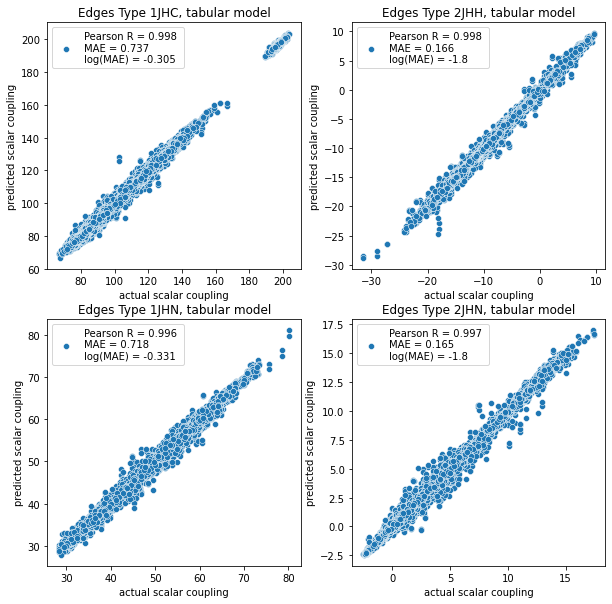

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 10])
p0 = plot_with_metrics(y_true_0, y_pred_0, ax1, int_to_type[0], "tabular")
p1 = plot_with_metrics(y_true_1, y_pred_1, ax2, int_to_type[1], "tabular")
p2 = plot_with_metrics(y_true_2, y_pred_2, ax3, int_to_type[2], "tabular")
p3 = plot_with_metrics(y_true_3, y_pred_3, ax4, int_to_type[3], "tabular")
plt.show()

In [19]:
def test_preds_multi(model, device, data, edge_type=0):
    # Set evaluation mode for encoder and decoder
    preds = []
    trues = []
    model.eval()
    test_losses = []
    with torch.no_grad(): # No need to track the gradients
        for i, batch in enumerate(data):
            x, edge_index, edge_attr, target, edge_cross, types = (batch["x"],
                                                               batch["edge_index"],
                                                               batch["edge_attr"],
                                                               batch["y"],
                                                               batch["nodes_target"],
                                                               batch["types"])
            types_cpu = types.numpy()
            if edge_type == 0:
                min_id = 0
                max_id = types [types == 0].shape[0]
            else:
                min_id = types [types < edge_type].shape[0]
                max_id = types [types < edge_type + 1].shape[0]
            sort_index = torch.Tensor(types.numpy().argsort(kind="stable")).long()
            target = target[sort_index]
            x, edge_index, edge_attr, target, edge_cross, types = x.to(device), \
                                                                edge_index.long().to(device), \
                                                                edge_attr.to(device), \
                                                                target.to(device),\
                                                                edge_cross.long().to(device), \
                                                                types.long().to(device)
            logits = model(x, edge_index, edge_attr, edge_cross, types)
            preds.append(logits.squeeze().cpu().numpy()[min_id:max_id])
            trues.append(target.squeeze().cpu().numpy()[min_id:max_id])
    return np.concatenate(trues), np.concatenate(preds)

In [22]:
with open("./test_dataloader.pkl", "rb") as f:
    test_dataloader_ = pickle.load(f)

In [11]:
from torch_geometric.nn import GCNConv, GATv2Conv, GATConv, SAGEConv

In [31]:
class GATv2EncoderGated(nn.Module):
    def __init__(self, num_node_features, hidden_features, heads, n_layers, p_dropout):
        super().__init__()
        self.p_dropout = p_dropout
        assert n_layers > 1
        self.init_conv = GATv2Conv(num_node_features, hidden_features, heads=n_heads, dropout=p_dropout,  edge_dim=8, concat=False)
        self.layers = nn.ModuleList([GATv2Conv(hidden_features, hidden_features, heads=n_heads, dropout=p_dropout,  edge_dim=8, concat=False) for i in range(n_layers)])
        self.gates = nn.Parameter(torch.Tensor(n_layers))
        self.init_conv.apply(init_weights)
        for conv in self.layers:
            conv.apply(init_weights)
    def forward(self, x, edge_index, edge_attr):
        range_gates = torch.sigmoid(self.gates)
        x = self.init_conv(x, edge_index, edge_attr)
        for i, layer in enumerate(self.layers):
            x = F.leaky_relu(x)
            x = (range_gates[i])*layer(x, edge_index, edge_attr) + (1-range_gates[i])*x
        return x
    
class ResNetGated(nn.Module):
    def __init__(self, init_dim, hidden_dim, layers, p_dropout):
        super().__init__()
        self.p_dropout = p_dropout
        assert n_layers > 1
        self.layers = nn.ModuleList([nn.Sequential(nn.Linear(init_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(p=p_dropout),
                             nn.Linear( hidden_dim, init_dim)) for i in range(layers)])
        self.gates = nn.Parameter(torch.Tensor(n_layers))
        self.layers.apply(init_weights)
    def forward(self, x):
        range_gates = torch.sigmoid(self.gates)
        for i, layer in enumerate(self.layers):
            x = F.relu(x)
            x = (range_gates[i])*layer(x) + (1-range_gates[i])*x
        return x

    
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, out_features, n_heads, n_layers, n_res, p_dropout):
        super().__init__()
        self.conv = GATv2EncoderGated(num_node_features, out_features, heads=n_heads, p_dropout=p_dropout,  n_layers=3)
        self.fcs = nn.ModuleList([nn.Sequential(ResNetGated(out_features*2, out_features*64, n_res, p_dropout),
                               nn.Linear(2 * out_features, 1)) for i in range(8)])
        for fc in self.fcs:
            fc.apply(init_weights)
    def forward(self, x, edge_index, edge_attr, edge_cross, types, return_embeddings = False):
        x = self.conv(x, edge_index, edge_attr)
        if return_embeddings:
            embeddings = x
        x = x[edge_cross]
        shp = x.shape
        x = x.transpose(1, 2).reshape([shp[0], shp[2]*2])
        xs = []
        for i in range(8):
            xs.append(self.fcs[i](x[types == i]))
        x = torch.concat(xs, axis=0)
        if return_embeddings:
            return x, embeddings
        return x

In [32]:
lr= 0.001
weight_decay = 0.000001
p_dropout = 0.001
conv_features = 128
n_heads = 6
n_layers = 3
n_res = 2
### Set the random seed for reproducible results
torch.manual_seed(0)

gcn = GCN(29, conv_features, n_heads, n_layers, n_res, p_dropout=p_dropout)
gcn.to(device)
saved_model = "./saved_models/with_resnet_2022-02-02-10:50:52_lr=0.001_wd=1e-06_p=0.001_conv_features=128_n_layers=3_n_res=2.pth"
gcn.load_state_dict(torch.load(saved_model))

<All keys matched successfully>

In [33]:
y_true_0, y_pred_0 = test_preds_multi(gcn, device, test_dataloader_, 0)
y_true_1, y_pred_1 = test_preds_multi(gcn, device, test_dataloader_, 1)
y_true_2, y_pred_2 = test_preds_multi(gcn, device, test_dataloader_, 2)
y_true_3, y_pred_3 = test_preds_multi(gcn, device, test_dataloader_, 3)

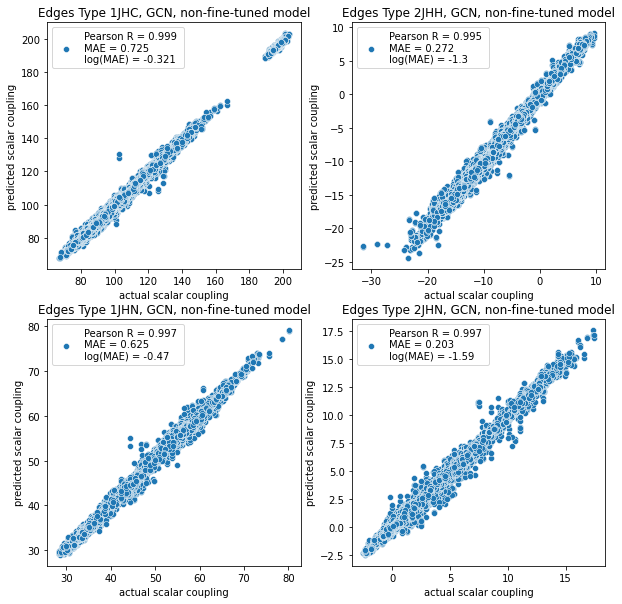

In [34]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 10])
p0 = plot_with_metrics(y_true_0, y_pred_0, ax1, int_to_type[0], "GCN, non-fine-tuned")
p1 = plot_with_metrics(y_true_1, y_pred_1, ax2, int_to_type[1], "GCN, non-fine-tuned")
p2 = plot_with_metrics(y_true_2, y_pred_2, ax3, int_to_type[2], "GCN, non-fine-tuned")
p3 = plot_with_metrics(y_true_3, y_pred_3, ax4, int_to_type[3], "GCN, non-fine-tuned")
plt.show()

In [35]:
gcn.load_state_dict(torch.load("./saved_models/with_resnet_2022-02-07-14:40:13_lr=0.001_wd=1e-06_p=0.001_conv_features=128_n_layers=3_n_res=2.pth"))
gcn.to(device)
y_true_0, y_pred_0 = test_preds_multi(gcn, device, test_dataloader_, 0)
gcn.load_state_dict(torch.load("./saved_models/MAE_resnet_2022-02-07-20:34:02_lr=0.001_wd=1e-06_p=0.001_conv_features=128_n_layers=3_n_res=2.pth"))
gcn.to(device)
y_true_1, y_pred_1 = test_preds_multi(gcn, device, test_dataloader_, 1)
gcn.load_state_dict(torch.load("./saved_models/MAE_resnet_2022-02-08-09:32:26_lr=0.001_wd=1e-06_p=0.001_conv_features=128_n_layers=3_n_res=2.pth"))
gcn.to(device)
y_true_2, y_pred_2 = test_preds_multi(gcn, device, test_dataloader_, 2)
gcn.load_state_dict(torch.load("./saved_models/MAE_resnet_2022-02-08-11:13:42_lr=0.001_wd=1e-06_p=0.001_conv_features=128_n_layers=3_n_res=2.pth"))
gcn.to(device)
y_true_3, y_pred_3 = test_preds_multi(gcn, device, test_dataloader_, 3)

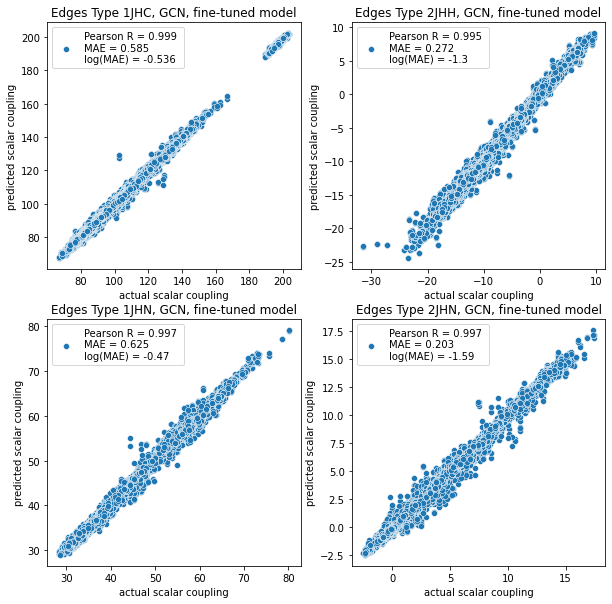

In [36]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 10])
p0 = plot_with_metrics(y_true_0, y_pred_0, ax1, int_to_type[0], "GCN, fine-tuned")
p1 = plot_with_metrics(y_true_1, y_pred_1, ax2, int_to_type[1], "GCN, fine-tuned")
p2 = plot_with_metrics(y_true_2, y_pred_2, ax3, int_to_type[2], "GCN, fine-tuned")
p3 = plot_with_metrics(y_true_3, y_pred_3, ax4, int_to_type[3], "GCN, fine-tuned")
plt.show()

In [24]:
class TransformerConvEncoderGated(nn.Module):
    def __init__(self, num_node_features, hidden_features, heads, n_layers, p_dropout):
        super().__init__()
        self.p_dropout = p_dropout
        assert n_layers > 1
        self.init_conv = TransformerConv(num_node_features, hidden_features, heads=n_heads, dropout=p_dropout,  edge_dim=8, concat=False)
        self.layers = nn.ModuleList([TransformerConv(hidden_features, hidden_features, heads=n_heads, dropout=p_dropout,  edge_dim=8, concat=False) for i in range(n_layers)])
        self.gates = nn.Parameter(torch.Tensor(n_layers))
        self.init_conv.apply(init_weights)
        for conv in self.layers:
            conv.apply(init_weights)
    def forward(self, x, edge_index, edge_attr):
        range_gates = torch.sigmoid(self.gates)
        x = self.init_conv(x, edge_index, edge_attr)
        for i, layer in enumerate(self.layers):
            x = F.leaky_relu(x)
            x = (range_gates[i])*layer(x, edge_index, edge_attr) + (1-range_gates[i])*x
        return x
    
class ResNetGated(nn.Module):
    def __init__(self, init_dim, hidden_dim, layers, p_dropout):
        super().__init__()
        self.p_dropout = p_dropout
        assert n_layers > 1
        self.layers = nn.ModuleList([nn.Sequential(nn.Linear(init_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(p=p_dropout),
                             nn.Linear( hidden_dim, init_dim)) for i in range(layers)])
        self.gates = nn.Parameter(torch.Tensor(n_layers))
        self.layers.apply(init_weights)
    def forward(self, x):
        range_gates = torch.sigmoid(self.gates)
        for i, layer in enumerate(self.layers):
            x = F.relu(x)
            x = (range_gates[i])*layer(x) + (1-range_gates[i])*x
        return x

    
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, out_features, n_heads, n_layers, n_res, p_dropout):
        super().__init__()
        # self.conv = TransformerConvEncoderGated(num_node_features, out_features, heads=n_heads, p_dropout=p_dropout,  n_layers=3)
        self.fcs = nn.ModuleList([nn.Sequential(ResNetGated(num_node_features*2, out_features*64, n_res, p_dropout),
                               nn.Linear(num_node_features*2, 1)) for i in range(8)])
        for fc in self.fcs:
            fc.apply(init_weights)
    def forward(self, x, edge_index, edge_attr, edge_cross, types):
        # x = self.conv(x, edge_index, edge_attr)
        x = x[edge_cross]
        shp = x.shape
        x = x.transpose(1, 2).reshape([shp[0], shp[2]*2])
        xs = []
        for i in range(8):
            xs.append(self.fcs[i](x[types == i]))
        x = torch.concat(xs, axis=0)
        return x

In [26]:
lr= 0.001
weight_decay = 0.000001
p_dropout = 0.001
conv_features = 128
n_heads = 6
n_layers = 3
n_res = 2
### Set the random seed for reproducible results
torch.manual_seed(0)

gcn = GCN(29, conv_features, n_heads, n_layers, n_res, p_dropout=p_dropout)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
gcn.load_state_dict(torch.load("./saved_models/with_resnet_2022-02-03-08:49:14_lr=0.001_wd=1e-06_p=0.001_conv_features=128_n_layers=3_n_res=2.pth"))
gcn.to(device)

GCN(
  (fcs): ModuleList(
    (0): Sequential(
      (0): ResNetGated(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=58, out_features=8192, bias=True)
            (1): ReLU()
            (2): Dropout(p=0.001, inplace=False)
            (3): Linear(in_features=8192, out_features=58, bias=True)
          )
          (1): Sequential(
            (0): Linear(in_features=58, out_features=8192, bias=True)
            (1): ReLU()
            (2): Dropout(p=0.001, inplace=False)
            (3): Linear(in_features=8192, out_features=58, bias=True)
          )
        )
      )
      (1): Linear(in_features=58, out_features=1, bias=True)
    )
    (1): Sequential(
      (0): ResNetGated(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=58, out_features=8192, bias=True)
            (1): ReLU()
            (2): Dropout(p=0.001, inplace=False)
            (3): Linear(in_features=8192, out_features=58, bias=T

In [27]:
y_true_0, y_pred_0 = test_preds_multi(gcn, device, test_dataloader_, 0)
y_true_1, y_pred_1 = test_preds_multi(gcn, device, test_dataloader_, 1)
y_true_2, y_pred_2 = test_preds_multi(gcn, device, test_dataloader_, 2)
y_true_3, y_pred_3 = test_preds_multi(gcn, device, test_dataloader_, 3)

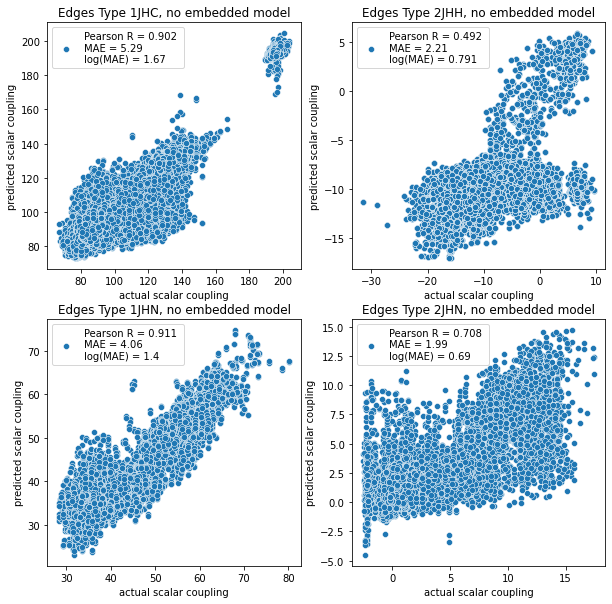

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 10])
p0 = plot_with_metrics(y_true_0, y_pred_0, ax1, int_to_type[0], "no embedded")
p1 = plot_with_metrics(y_true_1, y_pred_1, ax2, int_to_type[1], "no embedded")
p2 = plot_with_metrics(y_true_2, y_pred_2, ax3, int_to_type[2], "no embedded")
p3 = plot_with_metrics(y_true_3, y_pred_3, ax4, int_to_type[3], "no embedded")
plt.show()

In [7]:
class SCDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, training= True):
        super().__init__(root, transform, pre_transform)
        self.filenames = pd.read_csv("raw/processed_names.csv")
        self.charges = pd.read_csv("raw/mulliken_charges.csv")
        self.magnetic_shieldings = pd.read_csv("raw/magnetic_shielding_tensors.csv")
        self.dipole_moments = pd.read_csv("raw/dipole_moments.csv")
        self.potential_energy = pd.read_csv("raw/potential_energy.csv")
        self.target = pd.read_csv("raw/train.csv")
        self.structures = pd.read_csv("raw/structures.csv")
        self.molecule_names = molecule_names = np.unique(self.potential_energy["molecule_name"])
        if training:
            self.training_mask = np.loadtxt("./raw/training_mask2.csv").astype(bool)
            self.molecule_names = self.molecule_names[self.training_mask]
            
    def len(self) -> int:
        return len(self.molecule_names)
    def standarize(self):
        mms = MinMaxScaler([-4, 4])
        self.charges["mulliken_charge"] = mms.fit_transform(self.charges[["mulliken_charge"]]).squeeze()
        self.magnetic_shieldings.iloc[:, 2:] = mms.fit_transform(self.magnetic_shieldings.iloc[:, 2:])
        self.dipole_moments.iloc[:, 1:] = mms.fit_transform(self.dipole_moments.iloc[:, 1:])
        self.potential_energy["potential_energy"] = mms.fit_transform(self.potential_energy[["potential_energy"]]).squeeze()

    def preprocess(self, k = None):
        charges = self.charges
        magnetic_shieldings = self.magnetic_shieldings
        dipole_moments = self.dipole_moments
        potential_energy = self.potential_energy
        molecule_names = self.molecule_names
        target = self.target
        structures = self.structures
        dfs = [charges, magnetic_shieldings, dipole_moments, potential_energy, target, structures]
        for i in range(len(dfs)):
            dfs[i] = dfs[i].set_index("molecule_name", drop=True)
        charges, magnetic_shieldings, dipole_moments, potential_energy, target, structures = dfs
        atoms = structures["atom"].unique()
        atoms_id = {atoms[i]:i for i in range(len(atoms))}
        training_mask = []
        for x, name in enumerate(list(molecule_names)):
            any_training_edges = True
            coords = structures.loc[name][["x", "y", "z"]].to_numpy()
            n_nodes = coords.shape[0]
            print("{}/{}".format(x + 1, len(molecule_names)), end = "\r")
            # adj_mat
            atom_types = structures.loc[name]["atom"].replace(atoms_id).to_numpy()
            atom_onehot = np.zeros([n_nodes, len(atoms)])
            atom_onehot[np.arange(0, n_nodes), atom_types] = 1
            charge = charges.loc[name]["mulliken_charge"].to_numpy()
            shieldings = magnetic_shieldings.loc[name].iloc[:, 2:].to_numpy()
            node_features = np.concatenate([charge[:, None], shieldings, atom_onehot, coords], axis=1)
            with open("./processed2/{}_node_attr.csv".format(name), "wb") as f:
                np.savetxt(f, node_features)
            try:
                edges_target = target.loc[[name]]
                training_mask.append(True)
            except KeyError:
                training_mask.append(False)
                any_training_edges = False
                
            if any_training_edges:
                edges_target["type"] = edges_target["type"].replace(edge_to_int).astype(np.int64)
                scalar_coupling = edges_target.loc[:, ["atom_index_0", "atom_index_1","type","scalar_coupling_constant"]].to_numpy()
            else:
                scalar_coupling = np.array([-1, -1, -1, 0])
            with open("./processed2/{}_target.csv".format(name), "wb") as f:
                np.savetxt(f, scalar_coupling)
            # Graph features
            dipole_moment = dipole_moments.loc[name]
            norm_dipole = np.array([np.linalg.norm(dipole_moment)])
            potential = potential_energy.loc[name]
            graph_features = (np.concatenate([dipole_moment, norm_dipole, potential, np.array([n_nodes]), atom_onehot.sum(axis=0)]))
            with open("./processed2/{}_graph_features.csv".format(name), "wb") as f:
                np.savetxt(f, graph_features)
            # edge_features
            edgelist, edge_attr = get_edge_features(coords, dipole_moment)
            # metaedge
            second_nhood = edgelist[edge_attr[:, 2] == 1]
            second_nhood = np.unique(np.sort(second_nhood, axis=1), axis=0)
            first_nhood = edgelist[edge_attr[:, 1] == 1]
            first_nhood = np.unique(np.sort(first_nhood, axis=1), axis=0)
            is_in_first = [x in first_nhood.tolist() for x in second_nhood.tolist()]
            second_nhood = second_nhood[~np.array(is_in_first)]
            meta_edges = []
            normal_edges = []
            for i in first_nhood:
                for j in first_nhood:
                    meta_edge = np.unique(np.concatenate([i, j]))
                    if len(meta_edge) == 3:
                        for k in second_nhood:
                            is_in_meta = np.in1d(k, meta_edge)
                            if is_in_meta.all():
                                center_node = (np.setdiff1d(meta_edge, k))
                                meta_edges.append(np.array([k[0], center_node[0], k[1]]))
                                normal_edges.append(k)
            if len(meta_edges) > 0:         
                unique_dihedral_edges, is_unique = np.unique(np.stack(normal_edges), axis=0, return_index=True)
                meta_edges_un = np.stack(meta_edges)[is_unique]
                angles = []
                for me in meta_edges_un.astype(np.int64):
                    angles.append(get_dihedral(coords, me))
                dihedral_angles = np.zeros(edgelist.shape[0])
                for i in range(len(angles)):
                    is_edge = np.where(edgelist == unique_dihedral_edges[i], 1, 0).all(axis=1)
                    dihedral_angles[is_edge] = angles[i]
                    is_edge = np.where(edgelist == unique_dihedral_edges[i][::-1], 1, 0).all(axis=1)
                    dihedral_angles[is_edge] = angles[i]
            else:
                dihedral_angles = np.zeros(edgelist.shape[0])
            with open("./processed2/{}_edge_list.csv".format(name), "wb") as f:
                np.savetxt(f, edgelist)
            with open("./processed2/{}_edgeattr.csv".format(name), "wb") as f:
                np.savetxt(f, np.concatenate([edge_attr, dihedral_angles[:,None]], axis=1))
                
    def mem_load(self):
        self.mem = {}
        for i, molecule in enumerate(self.molecule_names):
            graph_features = pd.read_csv("./processed2/{}_graph_features.csv".format(molecule), sep=" ", header=None).to_numpy()
            node_features = pd.read_csv("./processed2/{}_node_attr.csv".format(molecule), sep=" ", header=None).to_numpy()
            atomtypes = node_features[:,-5:].argmax(axis=1)
            prop_atoms = props[atomtypes,:]
            n_nodes = node_features.shape[0]
            graph_features = np.tile(graph_features, [1, n_nodes]).T
            node_features = np.concatenate([prop_atoms, node_features, graph_features], axis=1)
            target =  pd.read_csv("./processed2/{}_target.csv".format(molecule), sep=" ", header=None).to_numpy()
            edge_type = target[:,2]
            edge_type = np.concatenate([edge_type, edge_type], axis=0)
            edges_target = target[:,0:2]
            target = target[:,3]
            target = np.concatenate([target, target])
            edges_target = np.concatenate([edges_target, edges_target[:,::-1]], axis=0)
            edge_list = pd.read_csv("./processed2/{}_edge_list.csv".format(molecule), sep=" ", header=None).to_numpy()
            edge_attr = pd.read_csv("./processed2/{}_edgeattr.csv".format(molecule), sep=" ", header=None).to_numpy()
            data = Data(x=torch.Tensor(node_features), edge_index = torch.Tensor(edge_list).T, y=torch.Tensor(target), edge_attr = torch.Tensor(edge_attr))
            data.nodes_target = torch.Tensor(edges_target)
            data.nodes = n_nodes
            data.edges = edge_list.shape[0]
            data.types = torch.Tensor(edge_type)
            # data.edge_cross = edgelist
            # data.nodes = node_features.shape[0]
            self.mem[molecule] = data
            print("{}/{}".format(i, len(self.molecule_names)), end = "\r")
            
    def __getitem__(self, idx):
        molecule = self.molecule_names[idx]
        return self.mem[molecule]
        

def get_distance_matrix(X, k=None):
    dist = squareform(pdist(X))
    if k is not None:
        non_k = dist.argsort(axis=1)[:, k+1:]
        dist[np.arange(0, dist.shape[0])[:,None], non_k] = 0
    return dist

def to_batch(list_graphs):
    n_nodes = 0
    for graph in list_graphs:
        graph["nodes_target"] += n_nodes
        n_nodes += graph.nodes
    return Batch.from_data_list(list_graphs) 

In [8]:
with open("./data_train_opt.pkl", "rb") as f:
    train_dataloader = pickle.load(f)
with open("./data_test_opt.pkl", "rb") as f:
    test_dataloader = pickle.load(f)

In [14]:
class GATv2EncoderGated(nn.Module):
    def __init__(self, num_node_features, hidden_features, heads, n_layers, p_dropout):
        super().__init__()
        self.p_dropout = p_dropout
        assert n_layers > 1
        self.init_conv = GATv2Conv(num_node_features, hidden_features, heads=n_heads, dropout=p_dropout,  edge_dim=9, concat=False)
        self.layers = nn.ModuleList([GATv2Conv(hidden_features, hidden_features, heads=n_heads, dropout=p_dropout,  edge_dim=9, concat=False) for i in range(n_layers-1)])
        self.gates = nn.Parameter(torch.Tensor(n_layers))
        self.init_conv.apply(init_weights)
        for conv in self.layers:
            conv.apply(init_weights)
    def forward(self, x, edge_index, edge_attr):
        range_gates = torch.sigmoid(self.gates)
        x = self.init_conv(x, edge_index, edge_attr)
        for i, layer in enumerate(self.layers):
            x = F.leaky_relu(x)
            x = (range_gates[i])*layer(x, edge_index, edge_attr) + (1-range_gates[i])*x
        return x
    
class ResNetGated(nn.Module):
    def __init__(self, init_dim, hidden_dim, layers, p_dropout):
        super().__init__()
        self.p_dropout = p_dropout
        assert n_layers > 1
        self.layers = nn.ModuleList([nn.Sequential(nn.Linear(init_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(p=p_dropout),
                             nn.Linear( hidden_dim, init_dim)) for i in range(layers)])
        self.gates = nn.Parameter(torch.Tensor(n_layers))
        self.layers.apply(init_weights)
    def forward(self, x):
        range_gates = torch.sigmoid(self.gates)
        for i, layer in enumerate(self.layers):
            x = F.relu(x)
            x = (range_gates[i])*layer(x) + (1-range_gates[i])*x
        return x

    
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, out_features, n_heads, n_layers, n_res, p_dropout):
        super().__init__()
        self.conv = GATv2EncoderGated(num_node_features, out_features, heads=n_heads, p_dropout=p_dropout,  n_layers=n_layers)
        self.fcs = nn.ModuleList([nn.Sequential(ResNetGated(out_features*2, out_features*64, n_res, p_dropout),
                               nn.Linear(2 * out_features, 1)) for i in range(8)])
        for fc in self.fcs:
            fc.apply(init_weights)
    def forward(self, x, edge_index, edge_attr, edge_cross, types):
        x = self.conv(x, edge_index, edge_attr)
        x = x[edge_cross]
        shp = x.shape
        x = x.transpose(1, 2).reshape([shp[0], shp[2]*2])
        xs = []
        for i in range(8):
            xs.append(self.fcs[i](x[types == i]))
        x = torch.concat(xs, axis=0)
        return x

In [17]:
### Define the loss function
loss_fn = nn.MSELoss

lr= 0.00078
weight_decay = 1.76755e-08
p_dropout = 0.0343089
conv_features = 128
n_heads = 3
n_layers = 3
n_res = 3
### Set the random seed for reproducible results
torch.manual_seed(0)

gcn = GCN(37, conv_features, n_heads, n_layers, n_res, p_dropout=p_dropout)
params_to_optimize = [
    {'params': gcn.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay)
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
gcn.load_state_dict(torch.load("./saved_models/with_resnet_2022-02-26-23:59:40_lr=0.00078_wd=1.76755e-08_p=0.0343089_conv_features=128_n_layers=3_n_res=3.pth"))
# Move both the encoder and the decoder to the selected device
gcn.to(device)

Selected device: cuda


GCN(
  (conv): GATv2EncoderGated(
    (init_conv): GATv2Conv(37, 128, heads=3)
    (layers): ModuleList(
      (0): GATv2Conv(128, 128, heads=3)
      (1): GATv2Conv(128, 128, heads=3)
    )
  )
  (fcs): ModuleList(
    (0): Sequential(
      (0): ResNetGated(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=256, out_features=8192, bias=True)
            (1): ReLU()
            (2): Dropout(p=0.0343089, inplace=False)
            (3): Linear(in_features=8192, out_features=256, bias=True)
          )
          (1): Sequential(
            (0): Linear(in_features=256, out_features=8192, bias=True)
            (1): ReLU()
            (2): Dropout(p=0.0343089, inplace=False)
            (3): Linear(in_features=8192, out_features=256, bias=True)
          )
          (2): Sequential(
            (0): Linear(in_features=256, out_features=8192, bias=True)
            (1): ReLU()
            (2): Dropout(p=0.0343089, inplace=False)
            (3): L

In [20]:
y_true_0, y_pred_0 = test_preds_multi(gcn, device, test_dataloader, 0)
y_true_1, y_pred_1 = test_preds_multi(gcn, device, test_dataloader, 1)
y_true_2, y_pred_2 = test_preds_multi(gcn, device, test_dataloader, 2)
y_true_3, y_pred_3 = test_preds_multi(gcn, device, test_dataloader, 3)

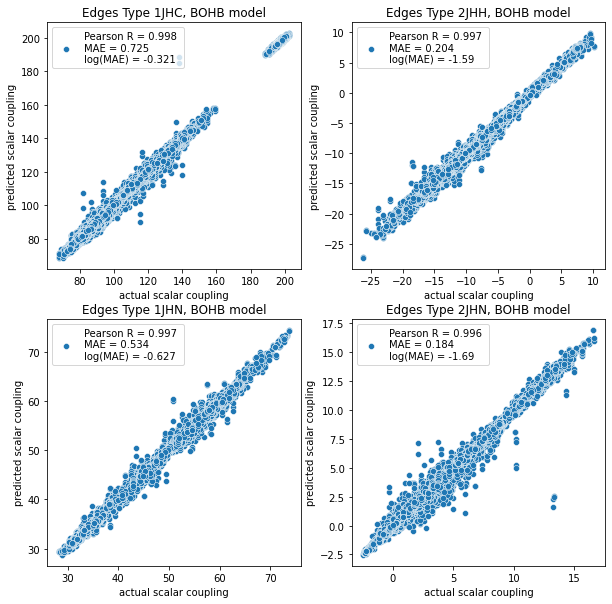

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 10])
p0 = plot_with_metrics(y_true_0, y_pred_0, ax1, int_to_type[0], "BOHB")
p1 = plot_with_metrics(y_true_1, y_pred_1, ax2, int_to_type[1], "BOHB")
p2 = plot_with_metrics(y_true_2, y_pred_2, ax3, int_to_type[2], "BOHB")
p3 = plot_with_metrics(y_true_3, y_pred_3, ax4, int_to_type[3], "BOHB")
plt.show()